
# Roamler

# Technical Assessment

Date: November 25th 2022

Author: Francisco Fernández

## Anomaly Detection

This notebooks simulates an aggregate EPOS dataset with anomalies and estimates several unsupervised classifications models models to detect these anomalies.

The notebook is organized as follows:

1. Initially, models are estimated in a smaller sample to show, in a smaller scale (without the test/train split), how the simulation behaves and how the models perform.
2. Afterwards, a complete set for a product is simulated and models are estimated in a single product, splitting the data and evaluating the models accordingly. 
3. The entire dataset is then simulated. For cumputational reasons the exercise is not performed on this dataset, but the exercise is essentially the same as that made in (2).

Given the simplicity of the simulated data, simple models show a great predictive power in this setting.

Case description:

Imagine you are given a dataset of about 2 years worth of (daily) EPOS data from 1500 stores and 75 products distributed unevenly over these stores.

We have no labels of previous anomalous results, and need to detect products that suddenly perform worse for a week or so.

We suspect that there can be several reasons for an anomaly:
- Product is becoming less attractive over time.
- Product has bad On Shelf Availability (this is the main interest point of ours)
-- Simply out of stock too much
-- Poor presentation on shelf
- Least likely: perhaps the quality of the data should be monitored on the clients' side, scanning errors etc.

How would you go about an anomaly model that can detect specifically #2? 
To give you a tip, we are looking specifically for a contrastive result of a store/product 
combination with respect to all other stores that the product is being sold at

In [1]:
#import packages

from cycler import cycler
from statsmodels.tsa.api import SARIMAX
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import cluster
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

random.seed(21)

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# Small sample case

Only one product is simulated for all stores. The data represents aggregated data for the product sold in the store.

The underlying assumption is that the product shares the same trend accross all stores.

The common trend of the product follows an ARIMA(2,0,1) model, but each store has a different level and a random error term.

$ts_{it} = ARIMA_{t} + \mu_{i} + \epsilon_{it} $

So the store $i$ in day $t$ has a different level $\mu_{i}$ and an error term $\epsilon_{it}$, assumed to be normally distributed for simplicity.

Anomalies are randomly generated for each store. If a randomly sampled binomial distrubution equals one, then a random quantity between a third and a quarter of the mean affects sales at the store for a random window of time between 7 and 30 days.

    if random.randint(0, 1) == 1:
        mu = random.uniform(0, 15)
        n = random.randrange(0, t)
        w = random.randrange(7, 30)
        x = df[i][n:min(n+w, t)].mean()
        alpha = random.uniform(x/4, x/3)
        df[i][n:min(n+w, t)] = df[i][n:min(n+w, t)] - alpha

Another essential assumption, for simplicity, is that prices are more or less constant and don't affect the models.

## Each row on the data reflects an aggregate quantity sold in a date, for a particular store, and a given price in date

In a more complex scenario, prices could be correlated with quantity sold and accross stores / geographical locations

Challenge: identify anomalies in quantity for more than a week.
Assumption: (for simplicity) prices don't have anomalies and are more os less constant over time
Assumption: every product has a similar time series distrution over time across stores 
 - essential for identification
Assumption: stores have different prices and quantity levels but similar error distribution

Distribution: products are unevenly distributed. As we are dealing with aggregate quantities, this should not affect results if the aggregate time series has a similar behaviour.

# I. Data Simulation: simple scenario, five stores for a single product.

In [2]:
t = 100
index = pd.date_range(end=datetime.today(), periods=t)
empty_dataset = np.zeros(150)
mod = SARIMAX(empty_dataset, order=(2, 0, 1), trend='c', initialization='diffuse')
simulations = mod.simulate([0.1, 5/3, -2/3, 5/6, 0.2**2], t + 50, random_state = 21)[50:]
sim = pd.Series(simulations)

### Plot underlying trend of the product

<Axes: >

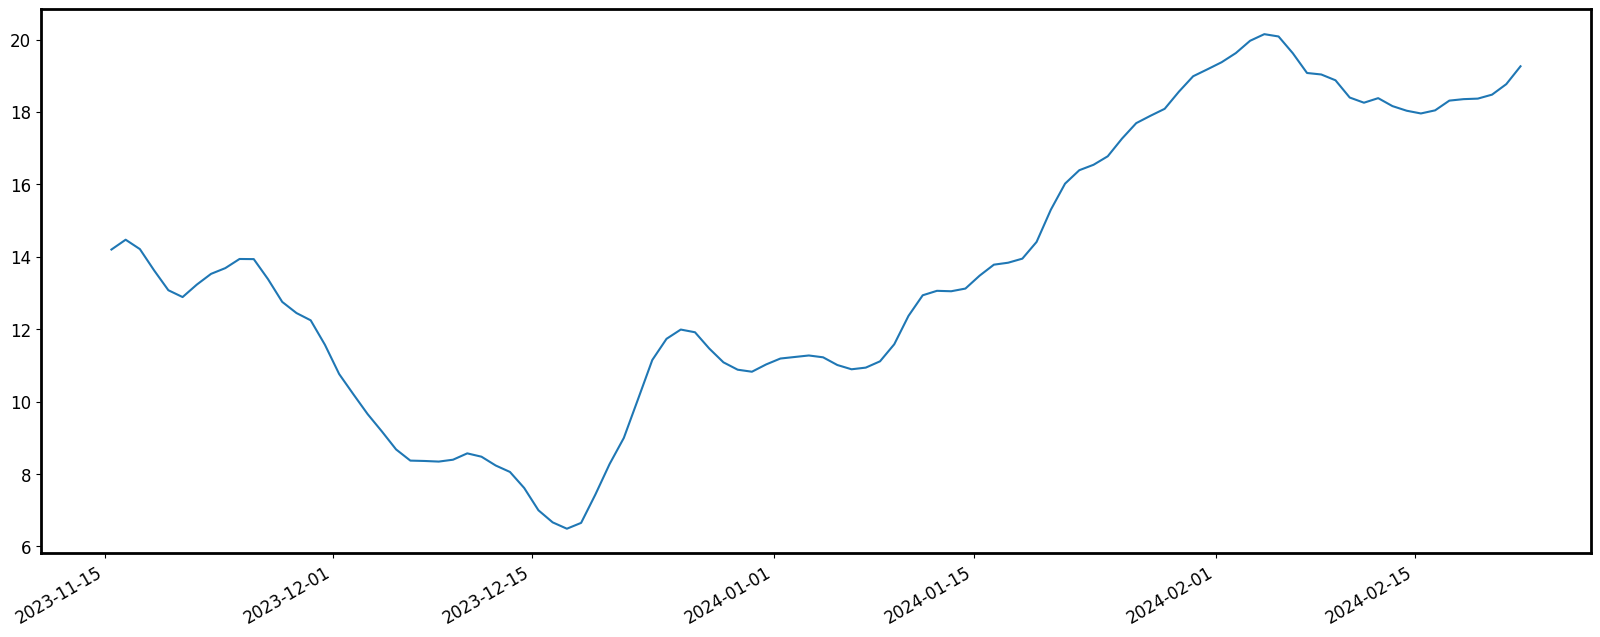

In [3]:
sim.index = index
sim.plot()

In [4]:
df = pd.DataFrame()
z = pd.DataFrame()

for i in range(5):

    mu = 0 # No intercept for simplicity
    e = np.random.normal(0, 1, t)
    df[i] = sim + mu + e
    
    z[i] = np.zeros(t).astype(int) # Empty array to register anomalies

    # generate anomaly
    
    v = random.randint(0, 1)

    if (v == 1):
        n = random.randrange(0, t)
        w = random.randrange(7, 30)
        x = df[i][n:min(n+w, t)].mean()
        alpha = 1.5 * random.uniform(x/4, x/3)
        df[i][n:min(n+w, t)] = df[i][n:min(n+w, t)] - alpha
        z[i][n:min(n+w, t)] = 1

z.index = index
df.index = index

C:\Users\31648\AppData\Local\Temp\ipykernel_21188\1701250706.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[i][n:min(n+w, t)] = df[i][n:min(n+w, t)] - alpha
C:\Users\31648\AppData\Local\Temp\ipykernel_21188\1701250706.py:22: FutureW

### Plot simulated data of the products

<Axes: >

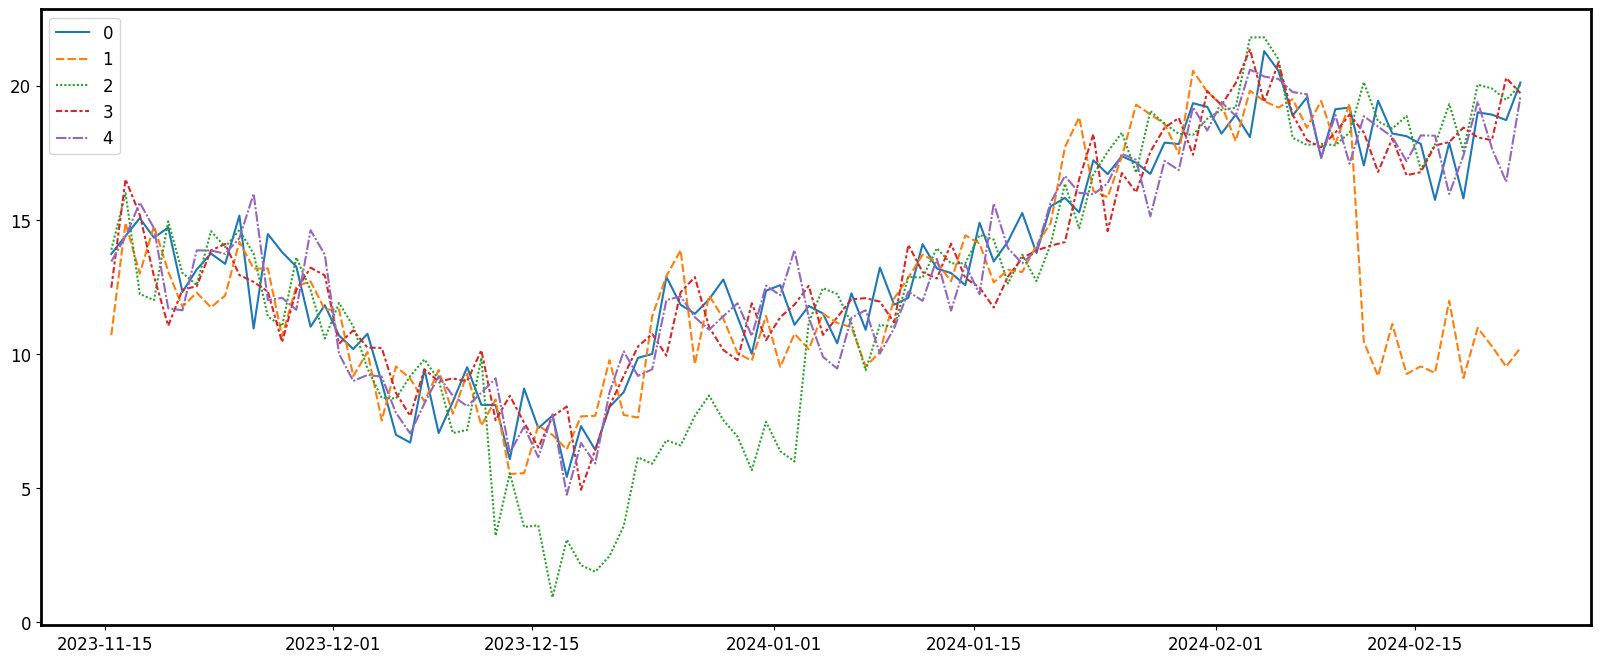

In [5]:
sns.lineplot(data=df)

# Challenge: How to deal with the trend?

Estimating directly a model without considering the trend would result in biased results, where some stores's values may be "low" because of some external cause (i.e., product is becoming less attractive over time) and not because there is an anomaly.

The central assumption of my estimation is that there is a common trend to the product so we can compare each store to this trend. We then compare the sales with the trend to detect any differences between each store and the exected sales. 

## Dimensionality reduction - PCA

A common and powerful method to obtain a low dimensional representation of large dataset is Principal Component Analysis. In time series it is frequantly used to detect elements as a common trend.

In [6]:
# normalize for PCA estimation

def normalization(x):
    return (x - x.mean()) / x.std()

pca = PCA(n_components=1)
pca.fit(df.apply(normalization))

loadings = pca.components_
loadings = abs(loadings) / np.sum(abs(loadings))

scores = np.dot(df,loadings.transpose())
scores = pd.DataFrame(scores, index = index)

pca = PCA(n_components=1)
pca.fit(df.apply(normalization))

loadings = pca.components_
loadings = abs(loadings) / np.sum(abs(loadings))

scores = np.dot(df,loadings.transpose())
scores = pd.DataFrame(scores, index = index)

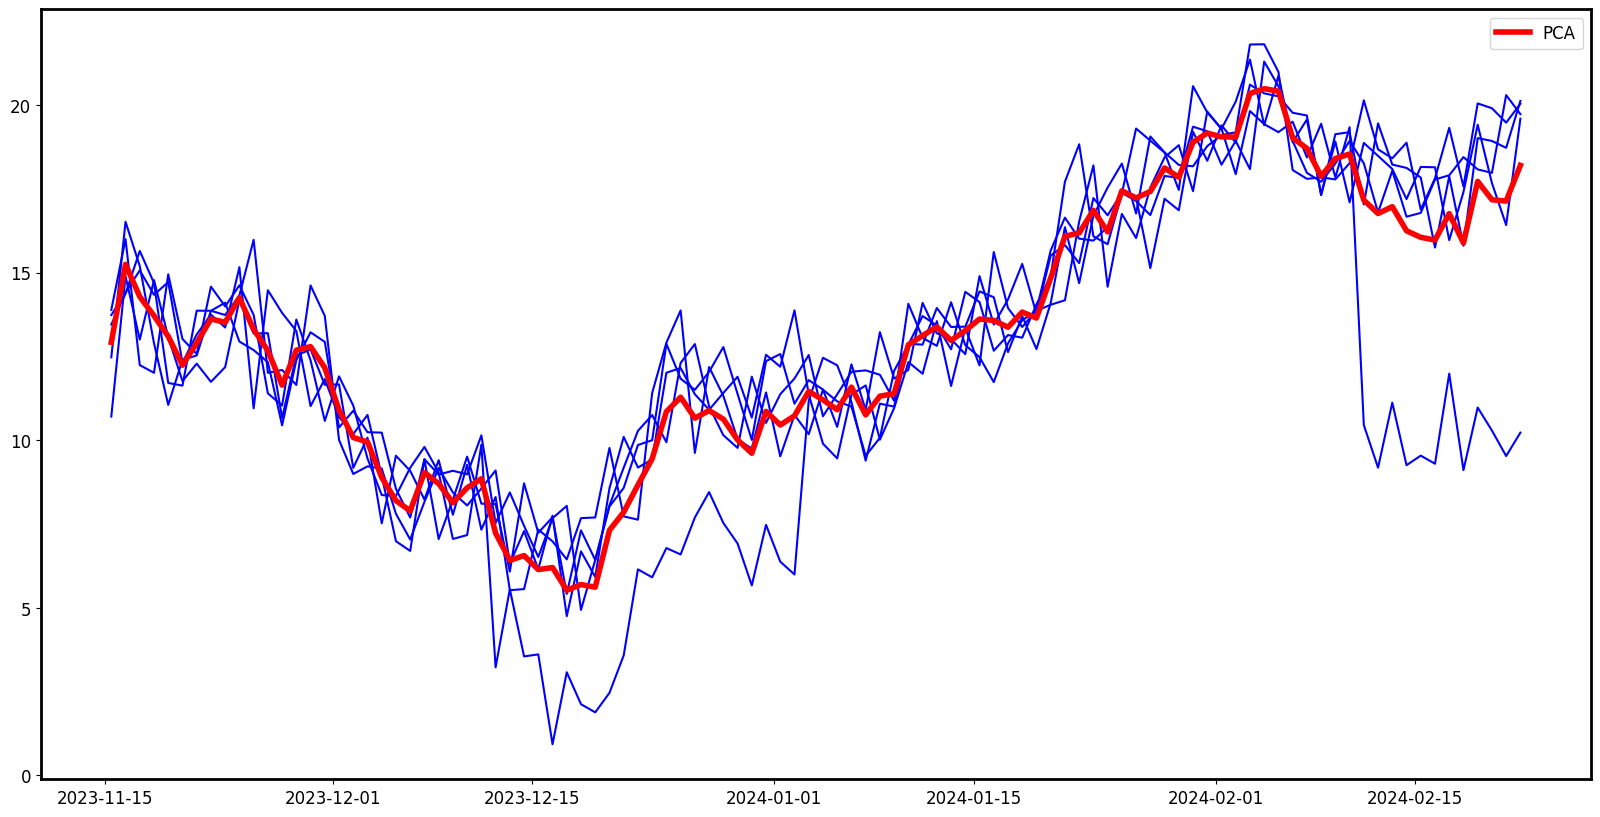

In [7]:
fig = plt.figure(figsize=(20, 10))
axs = fig.add_subplot(111)
axs.plot(df.index, df, color='blue')
axs.plot(scores.index, scores[0], label='PCA', color='red', linewidth=4)
axs.legend()

### The estimated trend is then substracted from the observed time series.

In [8]:
df1 = pd.DataFrame(index=index)

for i in range(5):
    df1[i] = df[i] - scores[0]

In [9]:
df1 = df1.stack()
df1

2023-11-15 10:05:53.518437  0    0.812967
                            1   -2.214707
                            2    0.967329
                            3   -0.448468
                            4    0.530130
                                   ...   
2024-02-22 10:05:53.518437  0    1.921021
                            1   -7.971405
                            2    1.835819
                            3    1.526173
                            4    1.389632
Length: 500, dtype: float64

In [10]:
z.stack()

2023-11-15 10:05:53.518437  0    0
                            1    0
                            2    0
                            3    0
                            4    0
                                ..
2024-02-22 10:05:53.518437  0    0
                            1    1
                            2    0
                            3    0
                            4    0
Length: 500, dtype: int32

# Unsupervised classification models

Two types of models could have interesting results in this setting: unsupervised learning models and anomaly score models. To tune hyperparameters of the models (number of clusters, anomaly threshold), BIC is used in this case considering that labels are not observed. 

In practice, we wouldn't be able to evaluate model accuracy performance across models as we can't observe labels. As in this case we know how data is generated, we can however verify in this simulation is the model correctly predicts actual anomalies.

In [11]:
X = np.array(df1)
X = X.reshape(-1, 1)

As this is just a small sample to show how the results behave, there is no train / test split yet.

# K-means

A good performance mesure in these type of models is the Bayesian Information Criteria, which will be used here to compare the optimal number of clusters than the classification models should estimate.

In [12]:
# BIC of Null K = 1 scenario

BIC = []

centers = [X.mean()]
N, d = X.shape
labels = np.ones((N,), dtype=int)

cl_var = (1.0 / (N - 1) / d) * sum((X - X.mean()) ** 2)
const_term = 0.5 * np.log(N) * (d+1)

BIC_0 = N * np.log(N) - N * np.log(N) - ((N * 1) / 2) * np.log(2*np.pi*cl_var) - ((N - 1) * 1 / 2) - const_term

BIC.append(float(BIC_0))

C:\Users\31648\AppData\Local\Temp\ipykernel_21188\1252574743.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BIC.append(float(BIC_0))


In [13]:
for i in range(2,5):
    clus = KMeans(n_clusters=i, random_state=0)
    clus.fit(X)
    labels = clus.predict(X)
    # BIC 
    centers = [X[labels == j].mean() for j in list(set(labels))]
    m = len(list(set(labels)))
    n = np.bincount(labels)
    N, d = X.shape
    cl_var = (1.0 / (N - m) / d) * sum([sum((X[np.where(labels == i)] - [centers[i]]) ** 2) for i in range(m)])
    const_term = 0.5 * m * np.log(N) * (d+1)
    BIC_j = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term
    BIC.append(BIC_j)
    
# Ideal number of clusters

m = np.argmax(BIC) + 1

if m != 1:
    clus = KMeans(n_clusters=m, random_state=0)
    clus.fit(X)
    labels = clus.predict(X)
else:
    labels = labels = np.ones((500,), dtype=int)

<Axes: xlabel='level_0', ylabel='0'>

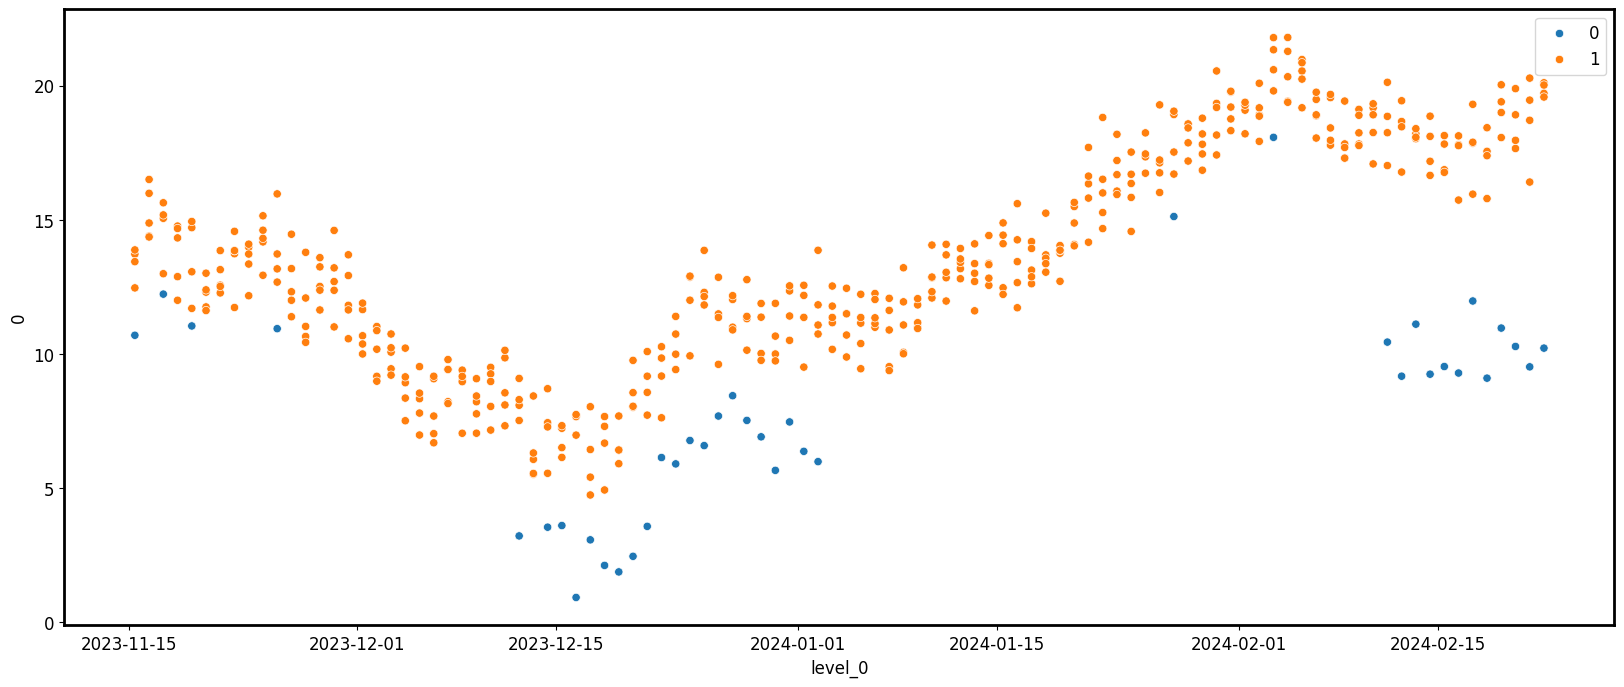

In [14]:
df2 = pd.DataFrame(df.stack())
df2 = df2.reset_index()
df2['labels'] = labels
sns.scatterplot(data = df2, x = df2.level_0, y = 0, hue=labels)

In [15]:
# We define 0 as the most frequent label

labels = (labels != np.nanargmax(np.bincount(labels))).astype(int)

In [16]:
labels = pd.DataFrame(np.reshape(labels, (-1,5), order='C'))

In [17]:
foo = pd.Categorical(np.array(z).flatten())
bar = pd.Categorical(np.array(labels).flatten())
pd.crosstab(foo, bar)

col_0,0,1
row_0,,
0,460,6
1,1,33


# Hierarchical clustering

In [18]:
# BIC of Null K = 1 scenario

BIC = []

centers = [X.mean()]
N, d = X.shape
labels = np.ones((N,), dtype=int)

cl_var = (1.0 / (N - 1) / d) * sum((X - X.mean()) ** 2)
const_term = 0.5 * np.log(N) * (d+1)

BIC_0 = N * np.log(N) - N * np.log(N) - ((N * 1) / 2) * np.log(2*np.pi*cl_var) - ((N - 1) * 1 / 2) - const_term

BIC.append(float(BIC_0))

C:\Users\31648\AppData\Local\Temp\ipykernel_21188\1252574743.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BIC.append(float(BIC_0))


In [19]:
for i in range(2,5):
    aggclust = AgglomerativeClustering(n_clusters = i).fit(X)
    aggclust.fit(X)
    labels = aggclust.labels_
    # BIC 
    centers = [X[labels == j].mean() for j in list(set(labels))]
    m = len(list(set(labels)))
    n = np.bincount(labels)
    N, d = X.shape
    cl_var = (1.0 / (N - m) / d) * sum([sum((X[np.where(labels == i)] - [centers[i]]) ** 2) for i in range(m)])
    const_term = 0.5 * m * np.log(N) * (d+1)
    BIC_j = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term
    BIC.append(BIC_j)
    
# Ideal number of clusters

m = np.argmax(BIC) + 1

if m != 1:
    clus = AgglomerativeClustering(n_clusters = m).fit(X)
    aggclust.fit(X)
    labels = aggclust.labels_
else:
    labels = labels = np.ones((500,), dtype=int)

<Axes: xlabel='level_0', ylabel='0'>

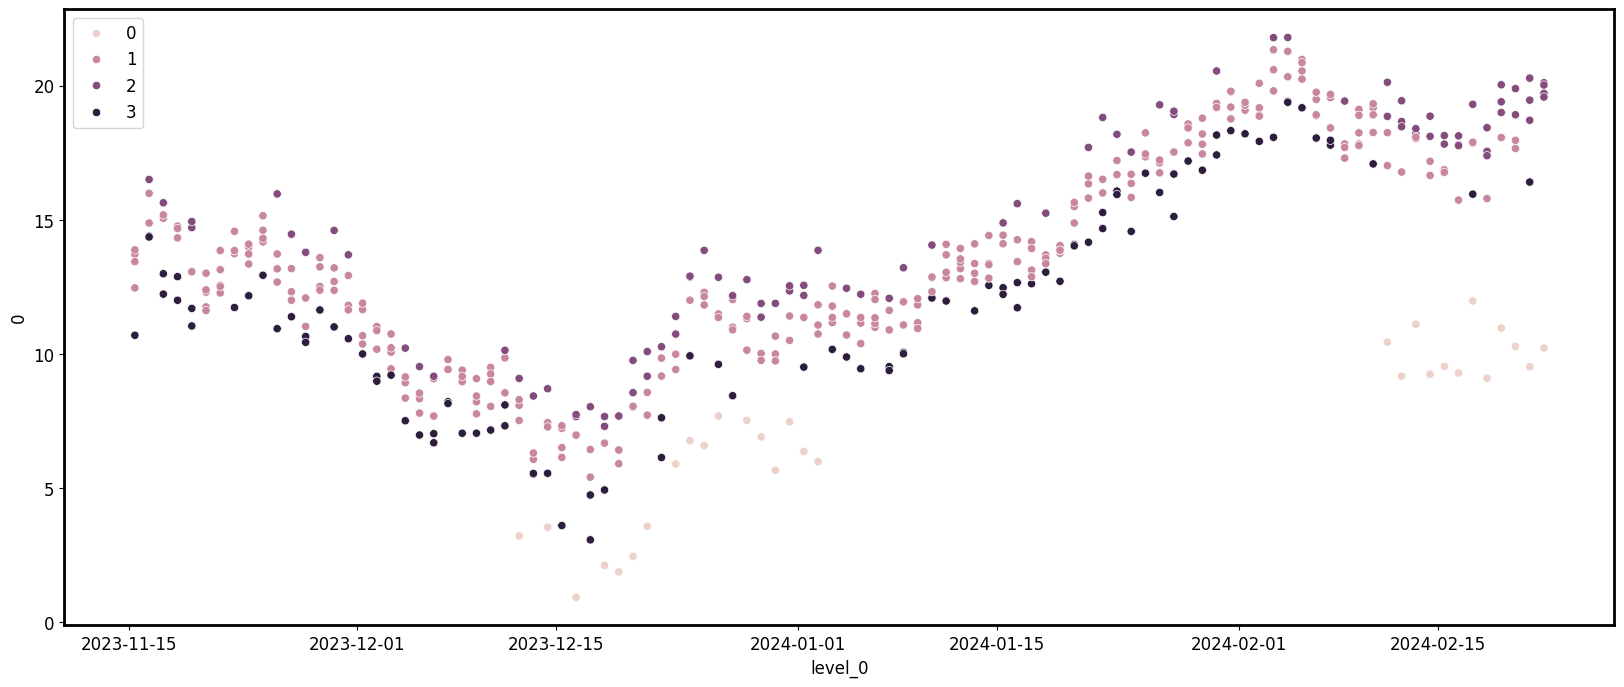

In [20]:
df2 = pd.DataFrame(df.stack())
df2 = df2.reset_index()
df2['labels'] = labels
sns.scatterplot(data = df2, x = df2.level_0, y = 0, hue=labels)

In [21]:
# We define 0 as the most frequent label

labels = (labels != np.nanargmax(np.bincount(labels))).astype(int)

In [22]:
labels = pd.DataFrame(np.reshape(labels, (-1,5), order='C'))

In [23]:
foo = pd.Categorical(np.array(z).flatten())
bar = pd.Categorical(np.array(labels).flatten())
pd.crosstab(foo, bar)

col_0,0,1
row_0,,
0,284,182
1,0,34


# Isolation forest

In [24]:
clf = IsolationForest(random_state=0).fit(X)

In [25]:
labels = (clf.predict(X) == 1).astype(int)

<Axes: xlabel='level_0', ylabel='0'>

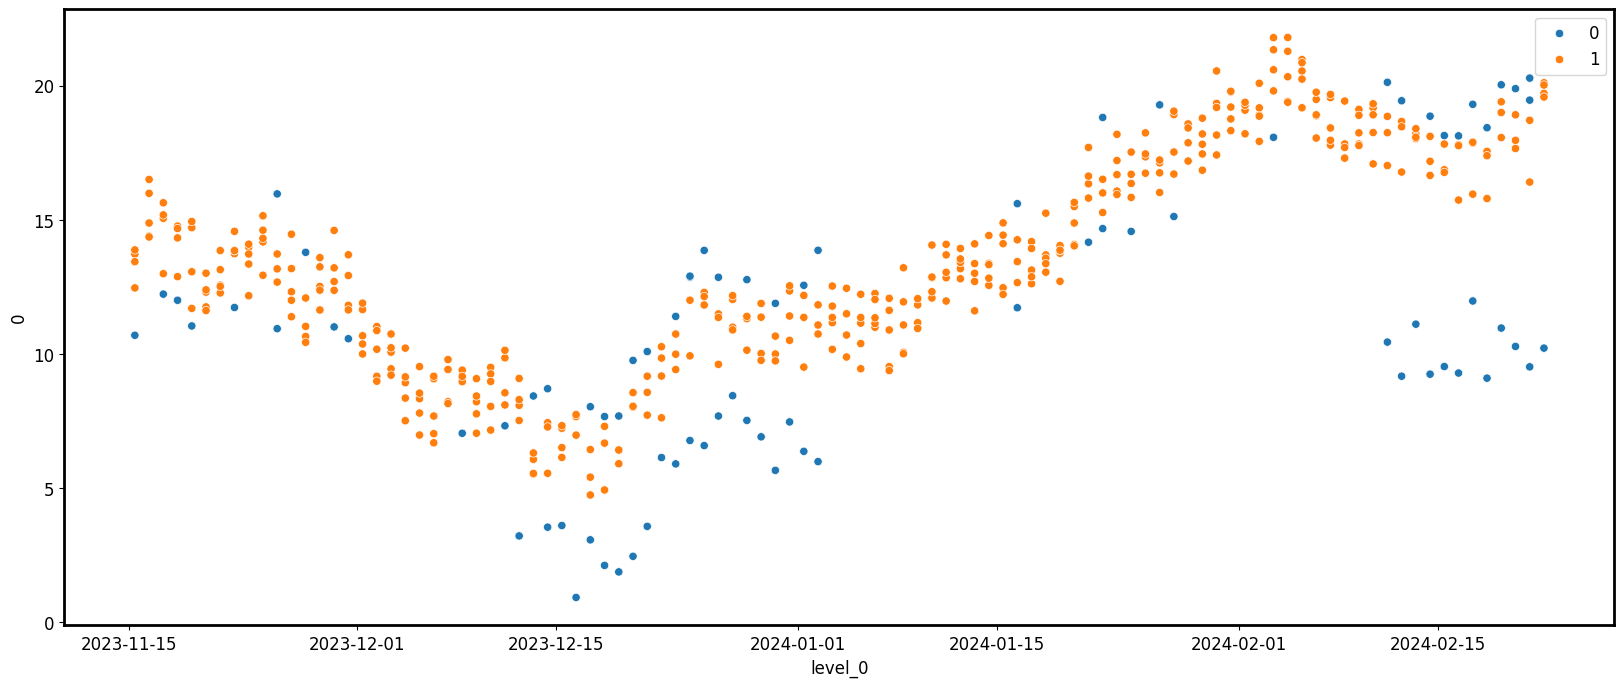

In [26]:
df2 = pd.DataFrame(df.stack())
df2 = df2.reset_index()
df2['labels'] = labels
sns.scatterplot(data = df2, x = df2.level_0, y = 0, hue=labels)

In [27]:
# We define 0 as the most frequent label

labels = (labels != np.nanargmax(np.bincount(labels))).astype(int)

In [28]:
labels = pd.DataFrame(np.reshape(labels, (-1,5), order='C'))

In [29]:
foo = pd.Categorical(np.array(z).flatten())
bar = pd.Categorical(np.array(labels).flatten())
pd.crosstab(foo, bar)

col_0,0,1
row_0,,
0,418,48
1,1,33


# Neural Network

In [30]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

In [31]:
model = Sequential()

# Simple NN - three layers with as many nodes as inputs

model.add(Dense(units=6, activation='linear',input_dim=6))
model.add(Dense(units=6, activation='linear'))
model.add(Dense(units=6, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [32]:
df1 = df1.reset_index()
df1 = df1.set_index('level_0')
df1[['d0','d1','d2','d3','d4']] = pd.get_dummies(df1.level_1)

In [33]:
df1 = df1.drop(['level_1'], axis = 1)

In [34]:
X = np.array(df1).astype('float32')

In [35]:
# Train the model
num_epochs = 10
batch_size = 256
history = model.fit(x=X, y=X,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X, X),
                    verbose=1)

Epoch 1/10


2/2 [==============================] - 1s 117ms/step - loss: 1.4598 - accuracy: 0.2380 - val_loss: 1.4291 - val_accuracy: 0.2400
Epoch 2/10
2/2 [==============================] - 0s 24ms/step - loss: 1.4185 - accuracy: 0.2400 - val_loss: 1.3908 - val_accuracy: 0.2420
Epoch 3/10
2/2 [==============================] - 0s 18ms/step - loss: 1.3822 - accuracy: 0.2420 - val_loss: 1.3538 - val_accuracy: 0.2440
Epoch 4/10
2/2 [==============================] - 0s 20ms/step - loss: 1.3460 - accuracy: 0.2440 - val_loss: 1.3181 - val_accuracy: 0.2480
Epoch 5/10
2/2 [==============================] - 0s 20ms/step - loss: 1.3097 - accuracy: 0.2480 - val_loss: 1.2838 - val_accuracy: 0.2500
Epoch 6/10
2/2 [==============================] - 0s 21ms/step - loss: 1.2761 - accuracy: 0.2500 - val_loss: 1.2509 - val_accuracy: 0.2520
Epoch 7/10
2/2 [==============================] - 0s 20ms/step - loss: 1.2433 - accuracy: 0.2520 - val_loss: 1.2192 - val_accuracy: 0.2540
Epoch 8/10
2/2 [=====================

In [36]:
pred = model.predict(X)

16/16 [==============================] - 0s 800us/step


In [37]:
# compute anomaly score
acc = np.sum((np.array(X) - \
                   np.array(pred))**2, axis=1)
acc = pd.Series(data=acc)
acc = (acc-np.min(acc))/(np.max(acc)-np.min(acc))
print('Mean for anomaly scores: ', np.mean(acc))

Mean for anomaly scores:  0.051590584


In [38]:
BIC = []
for x in [j/100 for j in range(15,85)]:
    l = [j for j in range(15,85)]
    labels = (acc >= x).astype(int)
    centers = [X[labels == j][0].mean() for j in list(set(labels))]
    m = len(list(set(labels)))
    N, d = X.shape
    cl_var = (1.0 / (N - m) / d) * sum([sum((X[labels == i][0] - [centers[i]]) ** 2) for i in range(m)])
    const_term = 0.5 * m * np.log(N) * (d+1)
    BIC_j = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term
    BIC.append(BIC_j)

In [39]:
labels = (acc >= l[np.argmax(BIC)] / 100).astype(int)

<Axes: xlabel='level_0', ylabel='0'>

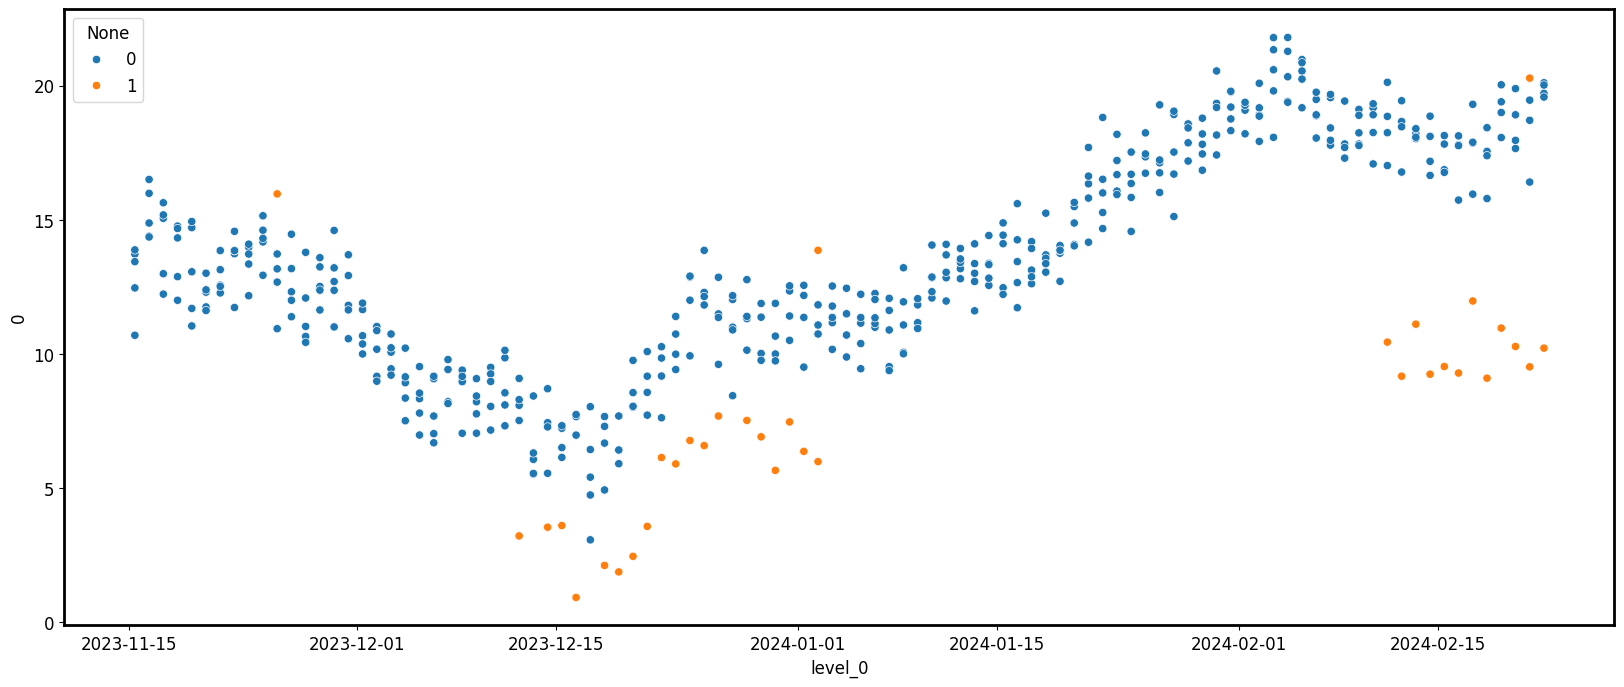

In [40]:
df2['labels'] = labels

df2 = pd.DataFrame(df.stack())
df2 = df2.reset_index()
df2['labels'] = labels
sns.scatterplot(data = df2, x = df2.level_0, y = 0, hue=labels)

In [41]:
# We define 0 as the most frequent label

labels = (labels != np.nanargmax(np.bincount(labels))).astype(int)

In [42]:
labels = pd.DataFrame(np.reshape(np.array(labels), (-1,5), order='C'))

In [43]:
foo = pd.Categorical(np.array(z).flatten())
bar = pd.Categorical(np.array(labels).flatten())
pd.crosstab(foo, bar)

col_0,0,1
row_0,,
0,463,3
1,3,31


# Large sample case
## Simulation for one product for a larger set and the entire period

In [44]:
t = 730
s = 150

index = pd.date_range(end=datetime.today(), periods=t)

In [45]:
empty_dataset = np.zeros(780)
mod = SARIMAX(empty_dataset, order=(2, 0, 1),
              trend='c', initialization='diffuse')
simulations = mod.simulate([0.1, 5/3, -2/3, 5/6, 0.2**2], t + 50, random_state = 12)[50:]

sim = pd.Series(simulations)

<Axes: >

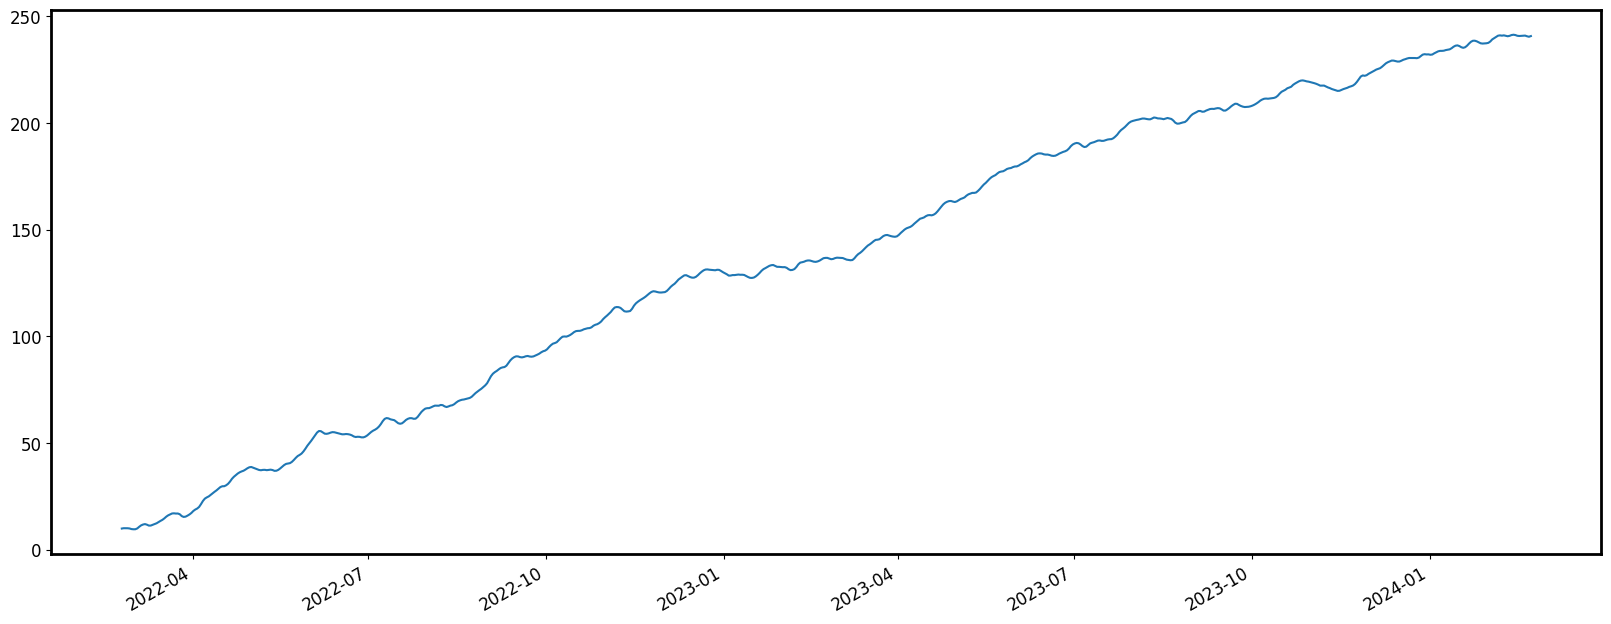

In [46]:
sim.index = index
sim.plot()

In [47]:
df = pd.DataFrame()
z = pd.DataFrame()

for i in range(s):

    mu = random.uniform(-5, 5)
    e = np.random.normal(0, 1, t)
    df[i] = sim + mu + e
    
    z[i] = np.zeros(t) # Empty array to register anomalies

    # generate anomaly
    
    v = random.randint(0, 1)

    if (v == 1):
        n = random.randrange(0, t)
        w = random.randrange(7, 30)
        x = df[i][n:min(n+w, t)].mean()
        alpha = random.uniform(x/4, x/3)
        df[i][n:min(n+w, t)] = df[i][n:min(n+w, t)] - alpha
        z[i][n:min(n+w, t)] = 1

z.index = index
df.index = index

C:\Users\31648\AppData\Local\Temp\ipykernel_21188\2780007357.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[i][n:min(n+w, t)] = df[i][n:min(n+w, t)] - alpha
C:\Users\31648\AppData\Local\Temp\ipykernel_21188\2780007357.py:22: FutureW

# PCA to obtain common trend

In [48]:
pca = PCA(n_components=1)
pca.fit(df.apply(normalization))

loadings = pca.components_
loadings = abs(loadings) / np.sum(abs(loadings))

scores = np.dot(df,loadings.transpose())
scores = pd.DataFrame(scores, index = index)

In [49]:
df1 = pd.DataFrame(index=index)

for i in range(s):

    df1[i] = df[i] - scores[0]

C:\Users\31648\AppData\Local\Temp\ipykernel_21188\2042452306.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[i] = df[i] - scores[0]
C:\Users\31648\AppData\Local\Temp\ipykernel_21188\2042452306.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[i] = df[i] - scores[0]
C:\Users\31648\AppData\Local\Temp\ipykernel_21188\2042452306.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

# Normalization of data and train / test split

Overfitting is still a concern in unsupervised learning - in this setting, predictin the past is not as important as predicting the future

In [50]:
df1 = normalization(df1)
df1 = df1.stack()
df1

2022-02-23 10:05:57.425248  0     -0.113594
                            1      0.017847
                            2      0.305757
                            3      0.181641
                            4      0.531552
                                     ...   
2024-02-22 10:05:57.425248  145    0.321702
                            146   -0.065460
                            147    0.083875
                            148    0.542238
                            149    0.323549
Length: 109500, dtype: float64

In [51]:
X = np.array(df1)

In [52]:
df1_train, df1_test = train_test_split(df1, test_size=0.33, random_state=21)
X_train, X_test = train_test_split(X, test_size=0.33, random_state=21)
df_train, df_test = train_test_split(df.stack(), test_size=0.33, random_state=21)

In [53]:
X_test

array([0.12381694, 0.39944864, 0.24592721, ..., 1.81560196, 0.37249479,
       0.99712307])

In [54]:
X_train

array([-0.53168785,  0.25060501,  1.12821188, ...,  0.78793888,
       -0.02433756,  0.83104458])

# Model Selection

Hierarchical Clustering and isolation forest are not estimated given the poor performance in the small sample.

# K-means

In [55]:
X = np.array(df1)
X = X.reshape(-1, 1)

X_train = np.array(df1_train)
X_train = X_train.reshape(-1, 1)

X_test = np.array(df1_test)
X_test = X_test.reshape(-1, 1)

In [56]:
# BIC of Null K = 1 scenario

BIC = []

centers = [X_test.mean()]
N, d = X_test.shape
labels = np.ones((N,), dtype=int)

cl_var = (1.0 / (N - 1) / d) * sum((X_test - X_test.mean()) ** 2)
const_term = 0.5 * np.log(N) * (d+1)

BIC_0 = N * np.log(N) - N * np.log(N) - ((N * 1) / 2) * np.log(2*np.pi*cl_var) - ((N - 1) * 1 / 2) - const_term

BIC.append(float(BIC_0))

C:\Users\31648\AppData\Local\Temp\ipykernel_21188\908275292.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BIC.append(float(BIC_0))


In [57]:
for i in range(2,5):
    clus = KMeans(n_clusters=i, random_state=0)
    clus.fit(X_train)
    labels = clus.predict(X_test)
    # BIC 
    centers = [X_test[labels == j].mean() for j in list(set(labels))]
    m = len(list(set(labels)))
    n = np.bincount(labels)
    N, d = X_test.shape
    cl_var = (1.0 / (N - m) / d) * sum([sum((X_test[np.where(labels == i)] - [centers[i]]) ** 2) for i in range(m)])
    const_term = 0.5 * m * np.log(N) * (d+1)
    BIC_j = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term
    BIC.append(BIC_j)
    
# Ideal number of clusters

m = np.argmax(BIC) + 1

if m != 1:
    clus = KMeans(n_clusters=m, random_state=0)
    clus.fit(X)
    labels = clus.predict(X)
else:
    labels = np.ones(len(X,), dtype=int)

In [58]:
len(X_test)

36135

In [59]:
pd.DataFrame(df_test)

,,0
2023-04-30 10:05:57.425248,140,158.878879
2022-10-05 10:05:57.425248,142,96.437910
2023-11-22 10:05:57.425248,138,213.739362
2022-08-07 10:05:57.425248,119,72.033412
2022-07-07 10:05:57.425248,110,65.103072
...,...,...
2022-04-30 10:05:57.425248,19,33.935259
2022-04-15 10:05:57.425248,112,32.894911
2023-04-26 10:05:57.425248,19,160.408130
2023-02-12 10:05:57.425248,129,141.159006


In [60]:
np.argmin([X[labels == j].mean() for j in list(set(labels))])

1

In [61]:
# We define 1 as cluster most distant to cetroid

labels = (labels == np.argmin([X[labels == j].mean() for j in list(set(labels))])).astype(int)

<Axes: xlabel='level_0', ylabel='0'>

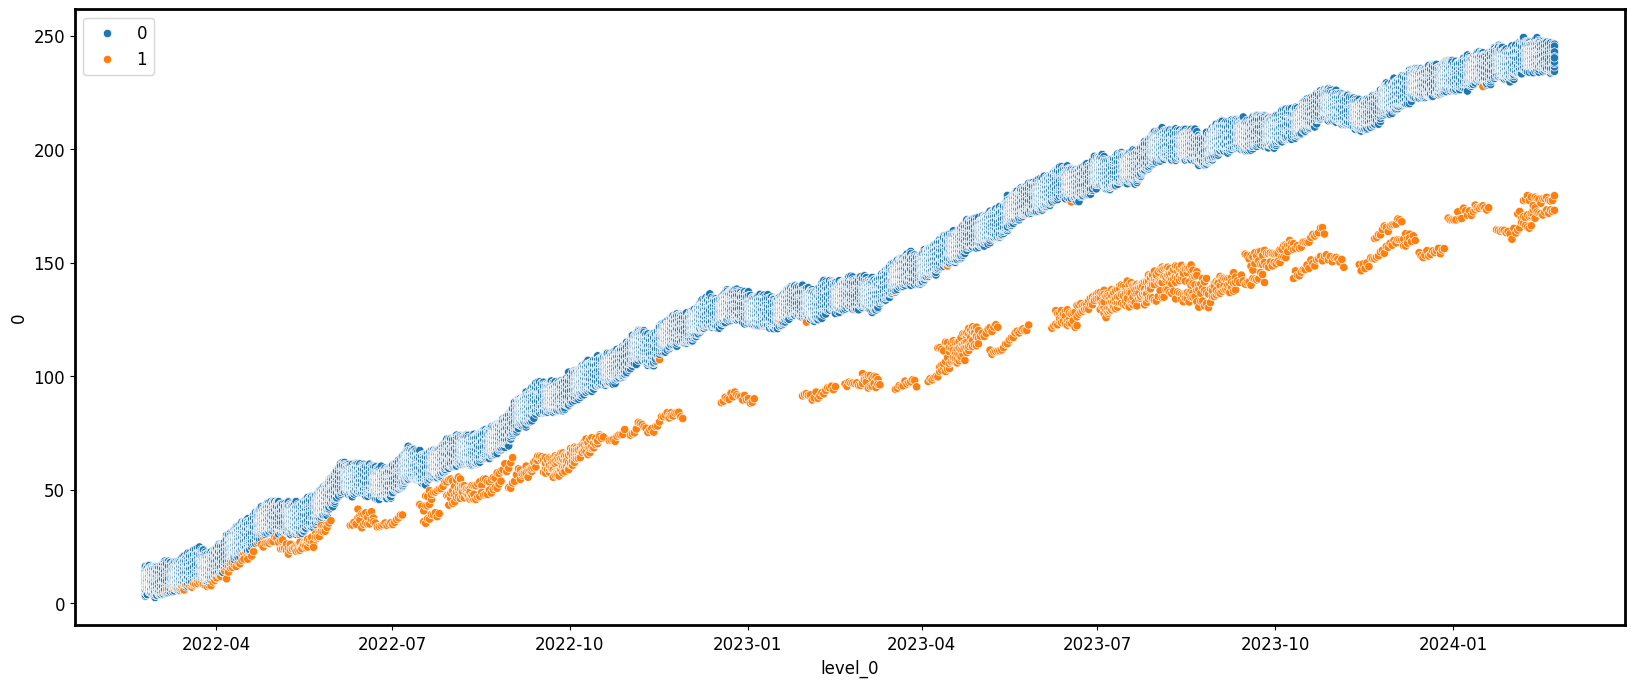

In [62]:
df2 = pd.DataFrame(df.stack())
df2 = df2.reset_index()
df2['labels'] = labels
sns.scatterplot(data = df2, x = df2.level_0, y = 0, hue=labels)

In [63]:
len(labels)

109500

In [64]:
labels = pd.DataFrame(np.reshape(labels, (-1,150), order='C'))

In [65]:
labels

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
726,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
727,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
728,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [66]:
z

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
2022-02-23 10:05:57.425248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-24 10:05:57.425248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-25 10:05:57.425248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-26 10:05:57.425248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-27 10:05:57.425248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-18 10:05:57.425248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-19 10:05:57.425248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-20 10:05:57.425248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-21 10:05:57.425248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### As we are considering anomalies that last longer than a week, we will set the labels to equal 1 if at least five days in a row out of seven had an anomaly

In [67]:
lab_roll = labels.rolling(7).sum()
lab_roll = lab_roll.applymap(lambda x: 1 if x >=3 else 0)
lab_roll

C:\Users\31648\AppData\Local\Temp\ipykernel_21188\3408295430.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lab_roll = lab_roll.applymap(lambda x: 1 if x >=3 else 0)


,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
726,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
727,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
728,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [68]:
u = pd.Categorical(np.array(z).flatten())
v = pd.Categorical(np.array(lab_roll).flatten())
pd.crosstab(u, v)

col_0,0,1
row_0,,
0.0,107835,300
1.0,171,1194


In [69]:
(pd.crosstab(u, v)[0][0] + pd.crosstab(u, v)[1][1]) / pd.crosstab(u, v).sum().sum()

0.9956986301369863

# Neural Network

In [70]:
df1

2022-02-23 10:05:57.425248  0     -0.113594
                            1      0.017847
                            2      0.305757
                            3      0.181641
                            4      0.531552
                                     ...   
2024-02-22 10:05:57.425248  145    0.321702
                            146   -0.065460
                            147    0.083875
                            148    0.542238
                            149    0.323549
Length: 109500, dtype: float64

In [71]:
df1 = df1.reset_index()
df1 = df1.set_index('level_0')
df1 = df1.rename(columns={0: "val"})
df1[pd.get_dummies(df1.level_1).columns] = pd.get_dummies(df1.level_1)
df1 = df1.drop(['level_1'], axis = 1)

C:\Users\31648\AppData\Local\Temp\ipykernel_21188\1036314498.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[pd.get_dummies(df1.level_1).columns] = pd.get_dummies(df1.level_1)
C:\Users\31648\AppData\Local\Temp\ipykernel_21188\1036314498.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[pd.get_dummies(df1.level_1).columns] = pd.get_dummies(df1.level_1)
C:\Users\31648\AppData\Local\Temp\ipykernel_21188\1036314498.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

In [72]:
df1

,val,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
level_0,,,,,,,,,,,,,,,,,,,,,
2022-02-23 10:05:57.425248,-0.113594,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-02-23 10:05:57.425248,0.017847,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-02-23 10:05:57.425248,0.305757,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-02-23 10:05:57.425248,0.181641,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-02-23 10:05:57.425248,0.531552,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22 10:05:57.425248,0.321702,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2024-02-22 10:05:57.425248,-0.065460,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2024-02-22 10:05:57.425248,0.083875,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [73]:
X = np.array(df1).astype('float32')

In [74]:
df1.shape

(109500, 151)

In [75]:
model = Sequential()

# Simple NN - three layers with as many nodes as inputs

nodes = df1.shape[1]

model.add(Dense(units=nodes, activation='linear',input_dim=nodes))
model.add(Dense(units=nodes, activation='linear'))
model.add(Dense(units=nodes, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [76]:
X_train, X_test = train_test_split(X, test_size=0.33, random_state=21)

In [77]:
X_train = X_train.reshape(-1, df1.shape[1])
X_train.shape

(73365, 151)

In [78]:
X_test = X_test.reshape(-1, df1.shape[1])
X_test.shape

(36135, 151)

In [79]:
nodes

151

In [80]:
# Train the model

num_epochs = 10
batch_size = 256
history = model.fit(x=X_train, y=X_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1)

Epoch 1/10


287/287 [==============================] - 1s 2ms/step - loss: 0.0033 - accuracy: 0.8362 - val_loss: 9.6569e-04 - val_accuracy: 0.9737
Epoch 2/10
287/287 [==============================] - 1s 2ms/step - loss: 5.3830e-04 - accuracy: 0.9855 - val_loss: 2.6281e-04 - val_accuracy: 0.9933
Epoch 3/10
287/287 [==============================] - 1s 3ms/step - loss: 1.5226e-04 - accuracy: 0.9963 - val_loss: 1.1727e-04 - val_accuracy: 0.9971
Epoch 4/10
287/287 [==============================] - 1s 2ms/step - loss: 8.8987e-05 - accuracy: 0.9979 - val_loss: 6.8039e-05 - val_accuracy: 0.9981
Epoch 5/10
287/287 [==============================] - 1s 2ms/step - loss: 4.5909e-05 - accuracy: 0.9990 - val_loss: 4.4385e-05 - val_accuracy: 0.9991
Epoch 6/10
287/287 [==============================] - 1s 2ms/step - loss: 1.0124e-05 - accuracy: 0.9998 - val_loss: 1.1827e-09 - val_accuracy: 1.0000
Epoch 7/10
287/287 [==============================] - 1s 2ms/step - loss: 8.0379e-10 - accuracy: 1.0000 - val_loss:

In [81]:
# compute anomaly score for test data

pred = model.predict(X_test)
acc = np.sum((np.array(X_test) - np.array(pred))**2, axis=1)
acc = pd.Series(data=acc)
acc = (acc-np.min(acc))/(np.max(acc)-np.min(acc))
print('Mean for anomaly scores: ', np.mean(acc))

1130/1130 [==============================] - 1s 564us/step
Mean for anomaly scores:  0.018679008


In [82]:
BIC = []
for x in [j/100 for j in range(5,95)]:
    l = [j for j in range(5,95)]
    labels = (acc >= x).astype(int)
    centers = [X_test[labels == j][0].mean() for j in list(set(labels))]
    m = len(list(set(labels)))
    N, d = X_test.shape
    cl_var = (1.0 / (N - m) / d) * sum([sum((X_test[labels == i][0] - [centers[i]]) ** 2) for i in range(m)])
    const_term = 0.5 * m * np.log(N) * (d+1)
    BIC_j = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term
    BIC.append(BIC_j)

In [83]:
labels = (acc >= l[np.nanargmax(BIC)] / 100).astype(int)
print('Threshold:',l[np.nanargmax(BIC)] / 100)

Threshold: 0.05


In [84]:
# compute anomaly score for all data

pred = model.predict(X)
acc = np.sum((np.array(X) - np.array(pred))**2, axis=1)
acc = pd.Series(data=acc)
acc = (acc-np.min(acc))/(np.max(acc)-np.min(acc))
labels = (acc >= l[np.nanargmax(BIC)] / 100).astype(int)

3422/3422 [==============================] - 2s 621us/step


<Axes: xlabel='level_0', ylabel='0'>

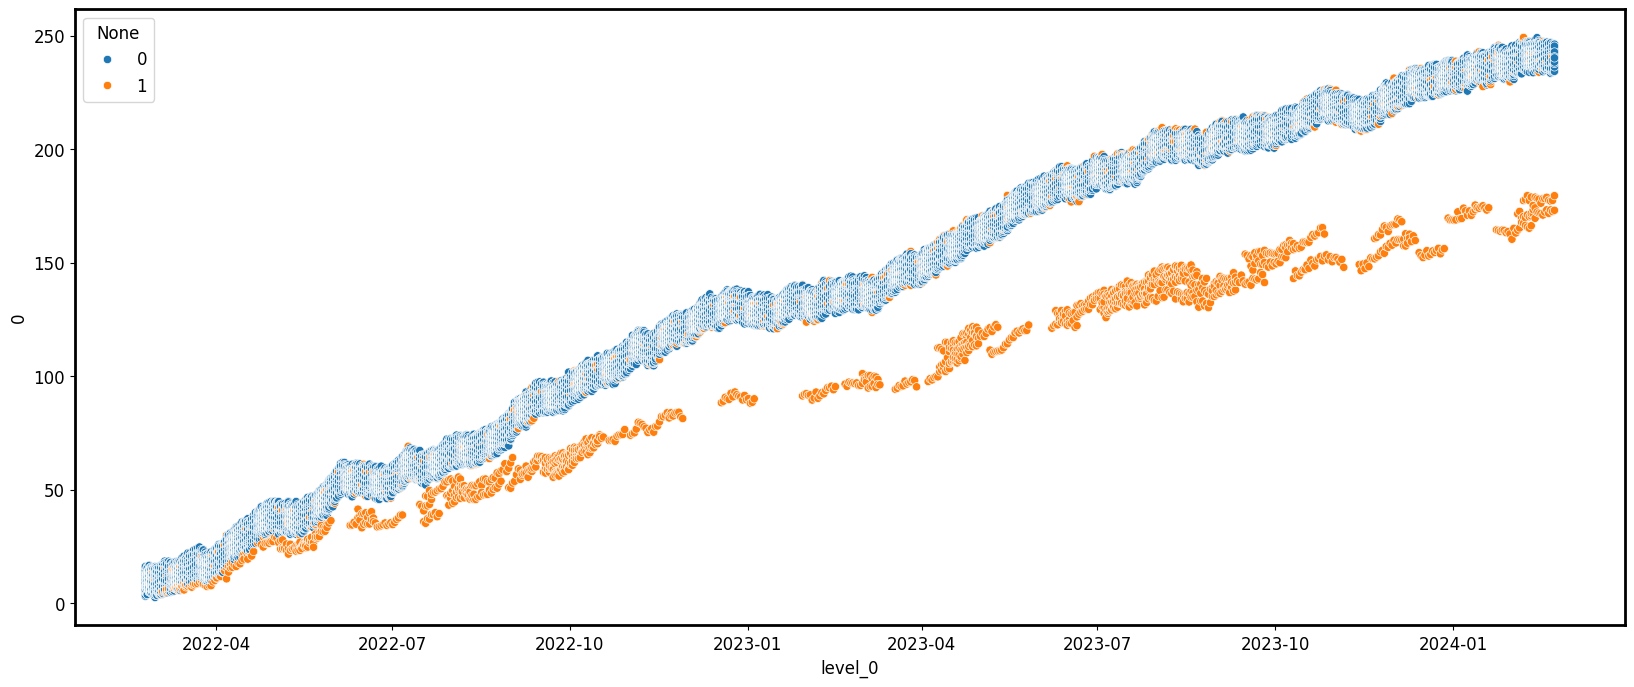

In [85]:
df2 = pd.DataFrame(df.stack())
df2 = df2.reset_index()
df2['labels'] = labels
sns.scatterplot(data = df2, x = df2.level_0, y = 0, hue=labels)

In [86]:
labels = np.array(labels)

In [87]:
labels = pd.DataFrame(np.reshape(labels, (-1,150), order='C'))

### As we are considering anomalies that last longer than a week, we will set the labels to equal 1 if at least five days in a row out of seven had an anomaly

In [88]:
lab_roll = labels.rolling(7).sum()

In [89]:
lab_roll = labels.rolling(7).sum()
lab_roll = lab_roll.applymap(lambda x: 1 if x >=3 else 0)
lab_roll

C:\Users\31648\AppData\Local\Temp\ipykernel_21188\3408295430.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lab_roll = lab_roll.applymap(lambda x: 1 if x >=3 else 0)


,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
726,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
727,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
728,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [90]:
u = pd.Categorical(np.array(z).flatten())
v = pd.Categorical(np.array(lab_roll).flatten())
pd.crosstab(u, v)

col_0,0,1
row_0,,
0.0,103283,4852
1.0,150,1215


In [91]:
(pd.crosstab(u, v)[0][0] + pd.crosstab(u, v)[1][1]) / pd.crosstab(u, v).sum().sum()

0.9543196347031964

# Evaluation

Both the simple unsupervised clustering methods (K-means) and anomaly score detection (using SNN) are having relatively good results, and most are correctly classifying anomalies, altough anomaly score detection is incorrectly labeling normal data as anomalies.

The relatevely good results are certainly explained by the simplicity of the simulated data, where simple models show a great predictive power in this setting. Both models seem to have problems identifying smaller gaps, and altough a Sequential Neural Networks has an impressive predictive power, it is wrongly classifying normal data as anomalies.

The assumptions behind the data generation process in this notebook are quite restrictive, and a more realistic setting would involve more complex interactions between stores, prices, and products. With increasing complexity, models as the NN would probably perform better.

In [92]:
raise ValueError('Simulation of complete dataset.')

ValueError: Simulation of complete dataset.

# III. Simulation of the whole dataset

A complete dataset is generated bellow. As models would be fitted for each product separately, and considering the dimensions of the data, the complete estimation of the models for all data is costly computationally. What follows is a sketch of how I would proceed given more computational power.

In [ ]:
t = 730
prod = 75
s = 1500

index = pd.date_range(end=datetime.today(), periods=t)

data = pd.DataFrame()
y = pd.DataFrame()

for j in range(prod):
    
    df = pd.DataFrame()
    z = pd.DataFrame()
    
    empty_dataset = np.zeros(780)
    mod = SARIMAX(empty_dataset, order=(2, 0, 1),trend='c', initialization='diffuse')
    simulations = mod.simulate([0.1, 5/3, -2/3, 5/6, 0.2**2], t + 50)[50:]
    sim = pd.Series(simulations)
    sim.index = index
    
    for i in range(s):
        
        mu = 0
        e = np.random.normal(0, 1, t)
        df[i] = sim + mu + e
        z[i] = np.zeros(t)

        # generate anomaly
        
        v = random.randint(0, 1)

        if (v == 1):
            n = random.randrange(0, t)
            w = random.randrange(7, 30)
            x = df[i][n:min(n+w, t)].mean()
            alpha = random.uniform(x/4, x/3)
            df[i][n:min(n+w, t)] = df[i][n:min(n+w, t)] - alpha
            z[i][n:min(n+w, t)] = 1
        
    # PCA

    pca = PCA(n_components=1)
    pca.fit(df.apply(normalization))

    loadings = pca.components_
    loadings = abs(loadings) / np.sum(abs(loadings))

    scores = np.dot(df,loadings.transpose())
    scores = pd.DataFrame(scores, index = index)

    for i in range(s):
        
        df[i] = df[i] - scores[0]

    df.index = index
    z.index = index
    df = df.stack()
    z = z.stack()
    y[j] = z
    data[j] = df

In [ ]:
index = data.index
data = data.reset_index()

# Model Selection

In [ ]:
def km(x):
    '''
    Function that takes series x and returns labels using k means
    '''

In [ ]:
def snn(x):
    '''
    Function that takes series x and returns labels using an anomaly scores estimated through a snn
    '''

In [ ]:
data = data.apply(normalization)

In [ ]:
l1 = []
l2 = []

for i in data.columns:
    df = data[i]
    
    X = np.array(data)
    
    
    df1_train, df1_test = train_test_split(data, test_size=0.33, random_state=21)
    X_train, X_test = train_test_split(X, test_size=0.33, random_state=21)
    
    # K means
    
    lab1 = km(df)
    
    # SNN
    
    lab2 = snn(df)
    
    # Store
    
    l1.append(lab1)
    l2.append(lab2)

In [ ]:
# Evaluate performance against actual anomalies

u = pd.Categorical(np.array(z).flatten())
v = pd.Categorical(np.array(lab_roll).flatten())
pd.crosstab(u, v)

# Ideas to improve in a more realistic setting


- Include clustering of similar products with correlated trends (e.g., waffles and syrup)
- Include geographical location of stores and see correlation with prices / sales
- Outlier detection in individual time series of the stores
- Include prices in the algorithm that could explain some variances in Qs